# Import Package

In [108]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import folium
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler

import xgboost as xgb
import lightgbm as lgb
from lightgbm.callback import log_evaluation

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, HalvingGridSearchCV
from sklearn.metrics import (r2_score,mean_absolute_error,mean_squared_error,mean_squared_log_error)

# Background

About the data:<br>
The dataset used for this analysis is derived from the 2016 NYC Yellow Cab trip record data, which was made accessible through Big Query on the Google Cloud Platform. The original source of the data is the NYC Taxi and Limousine Commission (TLC). It includes various fields such as the time and location of taxi pickups, along with drop-off locations and trip durations. The dataset comprises approximately 1.4 million trips that occurred during the first half of 2016.<br>

Features Description:
1. id - a unique identifier for each trip
2. vendor_id - a code indicating the provider associated with the trip record
3. pickup_datetime - date and time when the meter was engaged
4. dropoff_datetime - date and time when the meter was disengaged
5. passenger_count - the number of passengers in the vehicle (driver entered value)
6. pickup_longitude - the longitude where the meter was engaged
7. pickup_latitude - the latitude where the meter was engaged
8. dropoff_longitude - the longitude where the meter was disengaged
9. dropoff_latitude - the latitude where the meter was disengaged
10. store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
11. trip_duration - duration of the trip in seconds
***
Split train & test set 70:30 :
- train.csv - the training set (contains 1458644 trip records / 70%)
- test.csv - the testing set (contains 625134 trip records / 30%)
***
Data source: kaggle.com/competitions/nyc-taxi-trip-duration <br>

# Objective

Predict NYC Yellow Cab duration for each trip 

# Data Understanding

## Load Dataset

In [109]:
file_path = '/Your_Path/train.csv'

df = pd.read_csv(file_path)
df.shape

(1458644, 11)

In [110]:
df.head(1).T

,0
id,id2875421
vendor_id,2
pickup_datetime,2016-03-14 17:24:55
dropoff_datetime,2016-03-14 17:32:30
passenger_count,1
pickup_longitude,-73.982
pickup_latitude,40.768
dropoff_longitude,-73.965
dropoff_latitude,40.766
store_and_fwd_flag,N


## Data Information

In [111]:
df.info(verbose=True)
#df.info(verbose=True, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [112]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,1.535,1.665,-73.973,40.751,-73.973,40.752,959.492
std,0.499,1.314,0.071,0.033,0.071,0.036,5237.432
min,1.000,0.000,-121.933,34.360,-121.933,32.181,1.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,397.000
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,662.000
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,1075.000
max,2.000,9.000,-61.336,51.881,-61.336,43.921,3526282.000


## Target Distribution

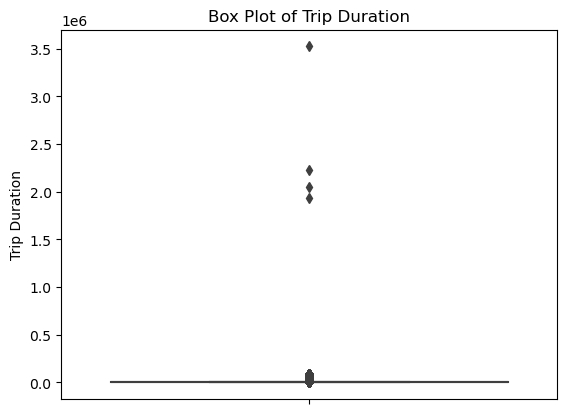

In [113]:
# Create a box plot
sns.boxplot(data=df, y='trip_duration')

# Set the plot title and labels
plt.title('Box Plot of Trip Duration')
plt.ylabel('Trip Duration')

# Display the plot
plt.show()

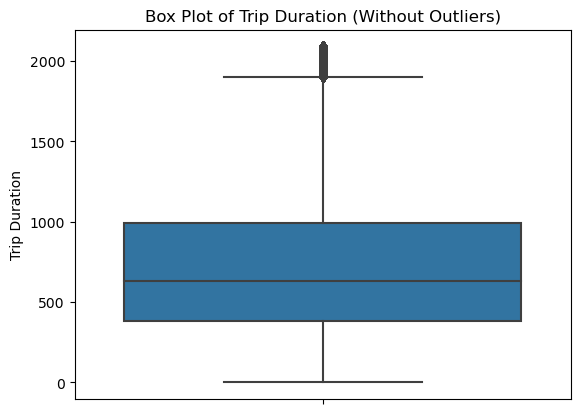

In [114]:
# Calculate the interquartile range (IQR)
Q1 = df['trip_duration'].quantile(0.25)
Q3 = df['trip_duration'].quantile(0.75)
IQR = Q3 - Q1

# Define the upper and lower bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
filtered_df = df[(df['trip_duration'] >= lower_bound) & (df['trip_duration'] <= upper_bound)]

# Create a box plot without outliers
sns.boxplot(data=filtered_df, y='trip_duration')

# Set the plot title and labels
plt.title('Box Plot of Trip Duration (Without Outliers)')
plt.ylabel('Trip Duration')

# Display the plot
plt.show()

It seems the target has extreme outliers which around 2,000-80,000 minutes. It means taxi driver is impossible to deliver passenger for more than 1+ day (2000 minutes).

In [115]:
# Count the number of outliers
outliers_count = ((df['trip_duration'] < lower_bound) | (df['trip_duration'] > upper_bound)).sum()
all_count = df['trip_duration'].count()
perc_outlier = outliers_count/all_count*100

# Print the count of outliers
print("Number of outliers:", outliers_count)
print(f"Percentage of outliers: {perc_outlier:.2f}%")

Number of outliers: 74220
Percentage of outliers: 5.09%


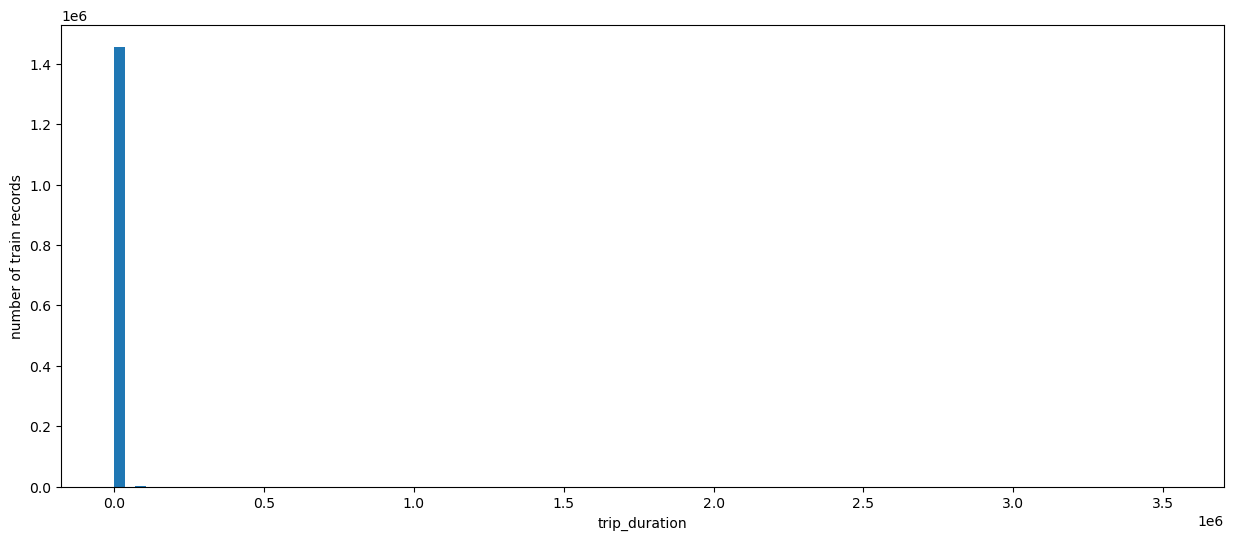

In [116]:
plt.figure(figsize=(15,6))
plt.hist(df['trip_duration'].values, bins=100)
plt.xlabel('trip_duration')
plt.ylabel('number of train records')
plt.show()

## Feature vs Target Correlation

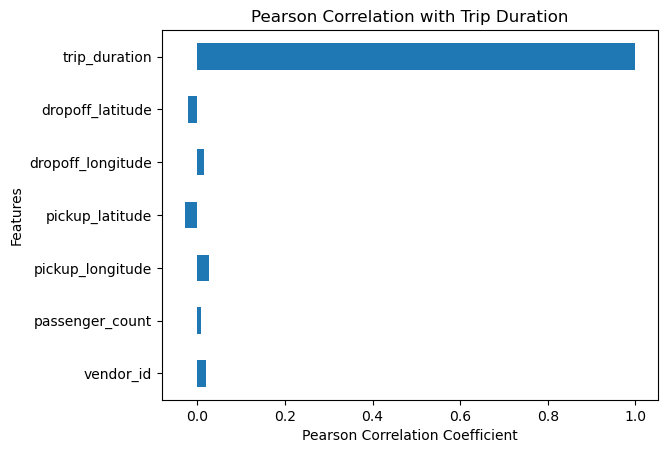

In [117]:
df.corr(method='pearson')['trip_duration'].plot(kind='barh')

# Set the plot title and labels
plt.title('Pearson Correlation with Trip Duration')
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('Features')

# Display the plot
plt.show()

# Data Preparation

## Drop Unused Feature

In [118]:
df_temp = df.copy()

In [119]:
def drop_feature(df_temp):
    df_temp = df_temp.drop(['id','vendor_id'], axis=1)
    return df_temp

## Duplicate & Missing Value

In [120]:
def simple_preprocessing(df_temp):
    df_temp = df_temp.drop_duplicates()
    df_temp = df_temp.dropna().reset_index(drop=True)

    return df_temp

## Build Modeling Function

## Fixing Date Format

In [121]:
df_temp['pickup_datetime'] = df_temp['pickup_datetime'].apply(pd.Timestamp)
df_temp['dropoff_datetime'] = df_temp['dropoff_datetime'].apply(pd.Timestamp)

## Apply Log Transformation to Target

In [122]:
df_temp['trip_duration'] = np.log(df_temp['trip_duration'].values + 1)

## Label Encoding (store_and_fwd_flag)

In [123]:
df_temp['store_and_fwd_flag'] = df_temp['store_and_fwd_flag'].astype('category').cat.codes

## Trip_duration Cleaning

As mentioned before, the target has extreme outliers which around 2,000-80,000 minutes. It means taxi driver is impossible to deliver passenger for more than 1+ day (2000 minutes). Hence I need to clean these.

In [124]:
# Calculate the interquartile range (IQR)
Q1 = df_temp['trip_duration'].quantile(0.25)
Q3 = df_temp['trip_duration'].quantile(0.75)
IQR = Q3 - Q1

# Define the upper and lower bounds for outlier detection
upper_bound = Q3 + 1.5 * IQR
upper_bound

8.472836343877669

I choose rounding to 1 days (2096 minutes) as upper bound.

In [125]:
df_temp = df_temp[df_temp['trip_duration'] <= 2096]

## Cleaning Pickup_longitude & Pickup_latitude

It seems the dropoff has wider scope than pickup. To provide the model with a more concise pattern, I have chosen to focus solely on New York City. Therefore I need find approach method by seeing in the google maps.

In [126]:
df_temp = df_temp[df_temp['pickup_longitude'] <= -73.75]
df_temp = df_temp[df_temp['pickup_longitude'] >= -74.03]
df_temp = df_temp[df_temp['pickup_latitude'] <= 40.85]
df_temp = df_temp[df_temp['pickup_latitude'] >= 40.63]
df_temp = df_temp[df_temp['dropoff_longitude'] <= -73.75]
df_temp = df_temp[df_temp['dropoff_longitude'] >= -74.03]
df_temp = df_temp[df_temp['dropoff_latitude'] <= 40.85]
df_temp = df_temp[df_temp['dropoff_latitude'] >= 40.63]

## Feature extract Hour, Day, Week, Month

In [127]:
df_temp['pickup_datetime'] = pd.to_datetime(df_temp['pickup_datetime']
                                           )
df_temp['dropoff_datetime'] = pd.to_datetime(df_temp['dropoff_datetime']
                                           )

In [128]:
# Extracting Datetime to Hour
df_temp['pickup_Hour'] = df_temp['pickup_datetime'].dt.hour
df_temp['dropoff_Hour'] = df_temp['dropoff_datetime'].dt.hour

# Extracting Datetime to Day
df_temp['pickup_Day'] = df_temp['pickup_datetime'].dt.day
df_temp['dropoff_Day'] = df_temp['dropoff_datetime'].dt.day

# Extracting Datetime to Week
df_temp['pickup_Week'] = df_temp['pickup_datetime'].dt.dayofweek
df_temp['dropoff_Week'] = df_temp['dropoff_datetime'].dt.dayofweek

# Extracting Datetime to Month
df_temp['pickup_Month'] = df_temp['pickup_datetime'].dt.month
df_temp['dropoff_Month'] = df_temp['dropoff_datetime'].dt.month

## Feature Extract Distance & Average Speed

Wikipedia said: A globally-average value is usually believed to be 6,371.0088 kilometres (3,959 mi) with a 0.3% variability (±10 km) for the following reasons.
Source: https://simple.wikipedia.org/wiki/Earth_radius

In [129]:
def haversine(lat1, long1, lat2, long2):
    lat1_rad, long1_rad, lat2_rad, long2_rad = np.radians([lat1, long1, lat2, long2])
    average_earth_rad = 6371
    lat_diff = lat2_rad - lat1_rad
    long_diff = long2_rad - long1_rad
    haversine = 2 * average_earth_rad * np.arcsin(np.sqrt(
                                                        np.sin(lat_diff * 0.5) ** 2
                                                        + np.cos(lat1_rad) * np.cos(lat2_rad)
                                                        * np.sin(long_diff * 0.5) ** 2))
    return haversine

df_temp['distance_haversine'] = haversine(df_temp['pickup_latitude'].values,
                                                     df_temp['pickup_longitude'].values,
                                                     df_temp['dropoff_latitude'].values,
                                                     df_temp['dropoff_longitude'].values)

In [130]:
# Need to drop since it can't input in deployment
#df_temp['avg_speed'] = 1000 * df_temp['distance_haversine'] / df_temp['trip_duration']

## Scaling

In [131]:
df_temp.head(1).T

,0
id,id2875421
vendor_id,2
pickup_datetime,2016-03-14 17:24:55
dropoff_datetime,2016-03-14 17:32:30
passenger_count,1
pickup_longitude,-73.982
pickup_latitude,40.768
dropoff_longitude,-73.965
dropoff_latitude,40.766
store_and_fwd_flag,0


In [132]:
df_temp.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_Hour', 'dropoff_Hour', 'pickup_Day',
       'dropoff_Day', 'pickup_Week', 'dropoff_Week', 'pickup_Month',
       'dropoff_Month', 'distance_haversine'],
      dtype='object')

In [133]:
df_temp = df_temp.select_dtypes(include=np.number)
df_temp.shape

(1439183, 17)

In [134]:
X = df_temp.drop('trip_duration', axis=1)
y = df_temp[['trip_duration']]

scaler = StandardScaler()
scaler.fit(X)
X_std = scaler.transform(X)

print(X_std.shape)
print(y.shape)

(1439183, 16)
(1439183, 1)


## Split Train and Test

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.3, random_state=33)

# Features Correlation

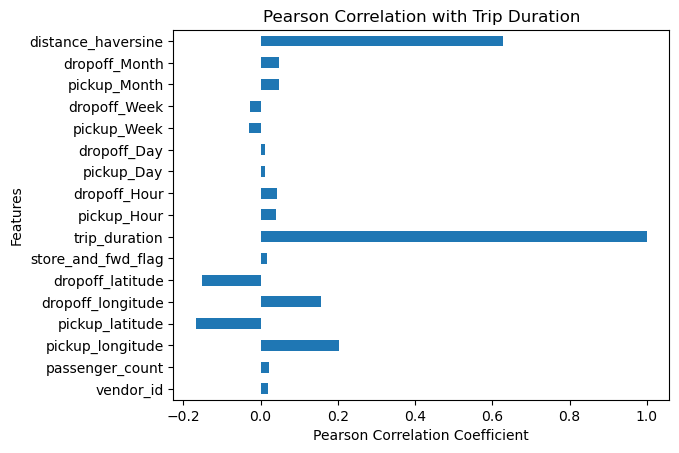

In [136]:
df_temp.corr(method='pearson')['trip_duration'].plot(kind='barh')

# Set the plot title and labels
plt.title('Pearson Correlation with Trip Duration')
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('Features')

# Display the plot
plt.show()

# Modeling

In [137]:
model = lgb.LGBMRegressor(verbose=-1)

model.fit(X_train, y_train.values.ravel())

# Predict the labels of the test set
y_pred_test = model.predict(X_test)

# Evaluation

In [138]:
# Calculate evaluation metrics for the training set
r2_train = r2_score(y_train, model.predict(X_train))
mae_train = mean_absolute_error(y_train, model.predict(X_train))
mse_train = mean_squared_error(y_train, model.predict(X_train))
rmse_train = np.sqrt(mean_squared_error(y_train, model.predict(X_train)))

# Calculate evaluation metrics for the test set
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

In [139]:
# Print the evaluation metrics for both training and test sets
print("Training set:")
print(f"R^2: {r2_train:.3f}")
print(f"MAE: {mae_train:.3f}")
print(f"MSE: {mse_train:.3f}")
print(f"RMSE: {rmse_train:.3f}")
print("\nTest set:")
print(f"R^2: {r2_test:.3f}")
print(f"MAE: {mae_test:.3f}")
print(f"MSE: {mse_test:.3f}")
print(f"RMSE: {rmse_test:.3f}")

Training set:
R^2: 0.754
MAE: 0.271
MSE: 0.153
RMSE: 0.391

Test set:
R^2: 0.753
MAE: 0.271
MSE: 0.153
RMSE: 0.391


# Cross Validation

References for below:  <br>
[1] K. Banachewicz, L. Massaron (2022). The Kaggle Book. Packt <br>
[2] LightGBM (2023). Parameters (accessed March 3rd, 2023) <br>
    https://lightgbm.readthedocs.io/en/latest/Parameters.html <br>
[3] LightGBM (2023). Parameters Tuning (accessed March 3rd, 2023) <br>
    https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html <br>
[4] M. Morohashi (2022). Kaggleで磨く機械学習の実践力. <br>
[5] Bex T. (2021). Kaggler’s Guide to LightGBM Hyperparameter Tuning with Optuna in 2021 (accessed March 3rd, 2023)<br>
    https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5 <br>
[6] Neptune.ai (accessed July 4th, 2023) <br>
https://neptune.ai/blog/lightgbm-parameters-guide <br>
[7] AWS Amazon SageMaker. Developer Guide (accessed July 4th, 2023) <br>
https://docs.aws.amazon.com/sagemaker/latest/dg/lightgbm-hyperparameters.html

**Deal with Over-fitting [3]**

* Use small max_bin
* Use small num_leaves
* Use min_data_in_leaf and min_sum_hessian_in_leaf
* Use bagging by set bagging_fraction and bagging_freq
* Use feature sub-sampling by set feature_fraction
* Use bigger training data
* Try lambda_l1, lambda_l2 and min_gain_to_split for regularization
* Try max_depth to avoid growing deep tree <br>

**For Better Accuracy [3]**
* Use large max_bin (may be slower)
* Use small learning_rate with large num_iterations
* Use large num_leaves (may cause over-fitting)
* Use bigger training data
* Try dart

Hyperparameter Introduction: https://towardsdatascience.com/beginners-guide-to-the-must-know-lightgbm-hyperparameters-a0005a812702

***

**To Get Good Result using a leaf-wise tree**

1. Num_leaves and max_depth (Tree Shape)

The parameter max_depth controls the maximum depth for the tree model [2].

* Default: -1 (no limit)
* Good starting point for baseline: Default
* Tuning range: (3, 16)

The parameter num_leaves controls the maximum number of leaves in one tree [2].

* Default: 31
* Good starting point for baseline: 16
* Tuning range: (8, 256) with num_leaves < 2^(max_depth) [3]

Hints: This is the main parameter to control the complexity of the tree model. Theoretically, we can set num_leaves = 2^(max_depth) to obtain the same number of leaves as depth-wise tree. However, this simple conversion is not good in practice. The reason is that a leaf-wise tree is typically much deeper than a depth-wise tree for a fixed number of leaves. Unconstrained depth can induce over-fitting. Thus, when trying to tune the num_leaves, we should let it be smaller than 2^(max_depth). For example, when the max_depth=7 the depth-wise tree can get good accuracy, but setting num_leaves to 127 may cause over-fitting, and setting it to 70 or 80 may get better accuracy than depth-wise. [3]

The smaller the trees (small num_leaves and max_depth), the faster the training speed — but this can also decrease accuracy [3].<br>
Pay attention If you use a large value of max_depth, your model will likely be over fit  to the train set.<br>
Since num_leaves impacts the tree growth in LGBM more than max_depth [5], Morohashi [4] doesn’t necessarily recommend tuning this parameter and to deviate from the default value.

2. min_data_in_leaf & min_gain_to_split (Tree Growth)

The parameter min_data_in_leaf specifies the minimum number of data points in one leaf [2]. If this parameter is too small, the model will overfit to the training data [2].
* Default: 20
* Good starting point for baseline: Default
* Tuning range: (5, 300) but depends on the size of the dataset. Hundreds are enough for a large dataset [3]. As a rule of thumb: The larger the dataset, the larger min_data_in_leaf.

The parameter min_gain_to_split specifies the minimum gain a leaf has to have to perform a split [2].

* Default: 0
* Good starting point for baseline: Default
* Tuning range: (0, 15)

If you limit tree growth by increasing the parameter min_gain_to_split, the resulting smaller trees will lead to a faster training time — but this can also decrease accuracy [3].

Hint: This is a very important parameter to prevent over-fitting in a leaf-wise tree. Its optimal value depends on the number of training samples and num_leaves. Setting it to a large value can avoid growing too deep a tree, but may cause under-fitting. In practice, setting it to hundreds or thousands is enough for a large dataset. (How many large?) [3]

***

**Data Sampling**

3. Bagging (rows sampling)<br>
At every bagging_freq-th iteration, LGBM will randomly select bagging_fraction * 100 % of the data to use for the next bagging_freq iterations [2]. E.g., if bagging_fraction = 0.8 and bagging_freq = 2, LGBM will sample 80 % of the training data every second iteration before training each tree. <br>

This technique can be used to speed up training [2].

* Default: bagging_fraction = 1.0 and bagging_freq = 0 (disabled)
* Good starting point for baseline: bagging_fraction = 0.9 and bagging_freq = 1
* Tuning range: bagging_fraction (0.5, 1)

4. Sub-feature sampling (columns sampling) <br>
Feature fraction or sub-feature deals with column sampling, LightGBM will randomly select a subset of features on each iteration (tree).[6] <br>
At every iteration, LGBM will randomly select feature_fraction * 100 % of the data [2]. <br>
E.g., if feature_fraction = 0.8, LGBM will sample 80 % of the features before training each tree.

* Default: 1
* Good starting point for baseline: 0.9
* Tuning range: (0.5, 1)

While sub-feature sampling can also be used to speed up training like bagging [2], it can help if there is multicollinearity present in the features [1].

**Regularization**

5. You can apply regularization techniques to your Machine Learning model to deal with overfitting. As the parameter names already suggest, the parameter lambda_l1 is used for L1 regularization and lambda_l2 for L2 regularization. <br>

* L1 regularization penalizes the absolute values of the weights and thus is robust against outliers
* L2 regularization penalizes the sum of squares of the weights and thus is sensitive to outliers

You can either decide to use only one of the two types of regularization or you can combine them if you like. For accuracy decrease, for generalization increase.<br>

For both parameters, the parameter values behave similarly:

* Default: 0 (disabled)
* Good starting point for baseline: Default
* Tuning range: (0.01, 100)

**Histogram Algorithm / Binning** (Improve training speed and reduce memory)

Binning is a technique for representing data in a discrete view(histogram). Lightgbm uses a histogram based algorithm to find the optimal split point while creating a weak learner. Therefore, each continuous numeric feature (e.g. number of views for a video) should be split into discrete bins. [6]

LightGBM training buckets continuous features into discrete bins to improve training speed and reduce memory requirements for training. This binning is done one time during Dataset construction. The number of splits considered when adding a node is O(#feature * #bin), so reducing the number of bins per feature can reduce the number of splits that need to be evaluated. [3]

max_bin is controls the maximum number of bins that features will bucketed into. It is also possible to set this maximum feature-by-feature, by passing max_bin_by_feature. [3]

Reduce max_bin or max_bin_by_feature to reduce training time. <br>
If you define max_bin 255 that means we can have a maximum of 255 unique values per feature. Then Small max_bin causes faster speed and large value improves accuracy.[3]

In [140]:
search_params = {
        "num_leaves" : [128, 256, 384],
        "max_depth" : [9, 10, 12, 14, 16],
        "min_data_in_leaf" : [100, 150, 200],
        "min_gain_in_leaf" : [7, 8, 9, 10],
        "bagging_fraction" : [0.5, 0.6, 0.7],
        "feature_fraction" : [0.7, 0.8, 0.9],
        "reg_alpha" : [0.01, 0.02, 0.03],
        "reg_lambda" : [0.01, 0.04, 0.08],
        "learning_rate" : [0.15, 0.18]
}

In [ ]:
%%time
warnings.filterwarnings("ignore")

# Create the HalvingGridSearchCV object instead of GridSearchCV because the data is large
grid_search = HalvingGridSearchCV(estimator=model, param_grid=search_params,
                                  cv=5, scoring='neg_root_mean_squared_error',
                                  factor=2, n_jobs=-1)

# Fit the HalvingGridSearchCV object to the training data
grid_search.fit(X_train, y_train.values.ravel())

In [142]:
grid_search.cv_results_

{'iter': array([ 0,  0,  0, ..., 13, 14, 14]),
 'n_resources': array([    61,     61,     61, ..., 499712, 999424, 999424]),
 'mean_fit_time': array([9.45963860e-03, 9.10544395e-03, 5.12423515e-03, ...,
        6.67917080e+00, 1.89463410e+01, 1.37965322e+01]),
 'std_fit_time': array([1.39961828e-03, 3.47191893e-03, 2.31628975e-03, ...,
        1.06208611e+00, 2.11740003e+00, 4.69911347e+00]),
 'mean_score_time': array([6.40583038e-04, 1.30515099e-03, 6.28137589e-04, ...,
        1.90226755e+00, 4.72345834e+00, 3.95357180e+00]),
 'std_score_time': array([2.42487866e-04, 1.32464725e-03, 5.20852277e-04, ...,
        3.25602261e-01, 1.84892800e-01, 1.04961348e+00]),
 'param_bagging_fraction': masked_array(data=[0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
              mask=[False, False, False, ..., False, False, False],
        fill_value='?',
             dtype=object),
 'param_feature_fraction': masked_array(data=[0.7, 0.7, 0.7, ..., 0.9, 0.9, 0.9],
              mask=[False, False, False, ...,

# Tuning Parameter

In [143]:
# Get the best parameters and best score from the grid search
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score (RMSE):", -best_score)  # Note the negative sign since GridSearchCV uses negative RMSE as the scoring metric

Best Parameters: {'bagging_fraction': 0.5, 'feature_fraction': 0.9, 'learning_rate': 0.15, 'max_depth': 12, 'min_data_in_leaf': 100, 'min_gain_in_leaf': 10, 'num_leaves': 256, 'reg_alpha': 0.02, 'reg_lambda': 0.08}
Best Score (RMSE): 0.3662252787305941


In [144]:
# Train the final model with the best hyperparameters on the entire training set
final_model = lgb.LGBMRegressor(**best_params, random_state=33,
                                max_bin=350, metric='rmse', verbosity=0)
final_model.fit(X_train, y_train)

[LightGBM] [Warning] Unknown parameter: min_gain_in_leaf
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


LGBMRegressor(bagging_fraction=0.5, feature_fraction=0.9, learning_rate=0.15,
              max_bin=350, max_depth=12, metric='rmse', min_data_in_leaf=100,
              min_gain_in_leaf=10, num_leaves=256, random_state=33,
              reg_alpha=0.02, reg_lambda=0.08, verbosity=0)

In [145]:
# Predict the labels of the test set
y_pred_train_final = final_model.predict(X_train)
y_pred_test_final = final_model.predict(X_test)

In [146]:
# Calculate evaluation metrics for the training set
r2_train_final = r2_score(y_train, y_pred_train_final)
mae_train_final = mean_absolute_error(y_train, y_pred_train_final)
mse_train_final = mean_squared_error(y_train, y_pred_train_final)
rmse_train_final = np.sqrt(mean_squared_error(y_train, y_pred_train_final))

# Calculate evaluation metrics for the test set
r2_test_final = r2_score(y_test, y_pred_test_final)
mae_test_final = mean_absolute_error(y_test, y_pred_test_final)
mse_test_final = mean_squared_error(y_test, y_pred_test_final)
rmse_test_final = np.sqrt(mean_squared_error(y_test, y_pred_test_final))

In [147]:
# Print the evaluation metrics for both training and test sets
print("Training set:")
print(f"R^2: {r2_train_final:.3f}")
print(f"MAE: {mae_train_final:.3f}")
print(f"MSE: {mse_train_final:.3f}")
print(f"RMSE: {rmse_train_final:.3f}")

print("\nTest set:")
print(f"R^2: {r2_test_final:.3f}")
print(f"MAE: {mae_test_final:.3f}")
print(f"MSE: {mse_test_final:.3f}")
print(f"RMSE: {rmse_test_final:.3f}")

print(f"Overfit ratio: {mse_test_final/mse_train_final:.3f}")

Training set:
R^2: 0.807
MAE: 0.236
MSE: 0.120
RMSE: 0.346

Test set:
R^2: 0.790
MAE: 0.242
MSE: 0.130
RMSE: 0.361
Overfit ratio: 1.084


# Hyperparameter Combination Searching Process:

**First Try: Some random initial values around the recommended range** <br>
* search_params = {
        "num_leaves" : [128, 256 , 512],
        "max_depth" : [8, 9, 10],
        "min_data_in_leaf" : [100, 150, 200],
        "min_gain_in_leaf" : [7, 8, 9, 10],
        "bagging_fraction" : [0.5, 0.6, 0.7],
        "feature_fraction" : [0.5, 0.6, 0.7],
        "reg_alpha" : [0.01, 0.04, 0.08],
        "reg_lambda" : [0.01, 0.04, 0.08],
        "learning_rate" : [0.03]
}
***
* Training set:
R^2: 0.865
MAE: 0.186
MSE: 0.084
RMSE: 0.290

* Test set:
R^2: 0.863
MAE: 0.187
MSE: 0.085
RMSE: 0.291
Overfit ratio: 1.011

> The error went higher than the baseline model, RMSE Tuning Model (0.291) > RMSE Base Model (0.205)

**Second Try: Try to get more max depth of tree (num_leaves follow) and slower learning rate**

* search_params = {
        "num_leaves" : [2048, 8192 , 32768],
        "max_depth" : [12, 14, 16],
        "min_data_in_leaf" : [100, 150, 200],
        "min_gain_in_leaf" : [7, 8, 9, 10],
        "bagging_fraction" : [0.5, 0.6, 0.7],
        "feature_fraction" : [0.5, 0.6, 0.7],
        "reg_alpha" : [0.01, 0.04, 0.08],
        "reg_lambda" : [0.01, 0.04, 0.08],
        "learning_rate" : [0.001,0.01]
}
***
Training set:
R^2: 0.918
MAE: 0.128
MSE: 0.051
RMSE: 0.226

Test set:
R^2: 0.913
MAE: 0.131
MSE: 0.054
RMSE: 0.233
Overfit ratio: 1.064

> The error still higher than the baseline model but better than the first one, RMSE Tuning Model (0.233) > RMSE Base Model (0.205)

**Third Try: Same hyperparameter like the first one but tried to bit faster learning rate (still intersect with second try range)**

search_params = {
        "num_leaves" : [128, 256 , 512],
        "max_depth" : [8, 9, 10],
        "min_data_in_leaf" : [100, 150, 200],
        "min_gain_in_leaf" : [7, 8, 9, 10],
        "bagging_fraction" : [0.5, 0.6, 0.7],
        "feature_fraction" : [0.5, 0.6, 0.7],
        "reg_alpha" : [0.01, 0.04, 0.08],
        "reg_lambda" : [0.01, 0.04, 0.08],
        "learning_rate" : [0.05, 0.07, 0.09]
}
***
Training set:
R^2: 0.931
MAE: 0.112
MSE: 0.043
RMSE: 0.207

Test set:
R^2: 0.925
MAE: 0.115
MSE: 0.046
RMSE: 0.215
Overfit ratio: 1.085

> The error went lower than the first try and more near to base model, RMSE Tuning Model (0.215) > RMSE Base Model (0.205), but the the overfitting ratio getting higher

**Fourth Try: Same like before but bit faster learning rate**

search_params = {
        "num_leaves" : [128, 256 , 512],
        "max_depth" : [9, 10, 12, 14, 16],
        "min_data_in_leaf" : [100, 150, 200],
        "min_gain_in_leaf" : [7, 8, 9, 10],
        "bagging_fraction" : [0.5, 0.6, 0.7],
        "feature_fraction" : [0.5, 0.6, 0.7],
        "reg_alpha" : [0.01, 0.02, 0.03],
        "reg_lambda" : [0.01, 0.04, 0.08],
        "learning_rate" : [0.15, 0.18]
}
***
Training set:
R^2: 0.958
MAE: 0.067
MSE: 0.026
RMSE: 0.161

Test set:
R^2: 0.947
MAE: 0.071
MSE: 0.033
RMSE: 0.181
Overfit ratio: 1.266

> The error of tuning model better than base model for 11,71% with RMSE Tuning Model (0.181) > RMSE Base Model (0.205) but the overfitting ratio is higher than before.

**Final Try: I try to lowering the upper limit and get higher column sampling (feature_fraction) to overcome the overfitting**

search_params = {
        "num_leaves" : [128, 256, 384],
        "max_depth" : [9, 10, 12, 14, 16],
        "min_data_in_leaf" : [100, 150, 200],
        "min_gain_in_leaf" : [7, 8, 9, 10],
        "bagging_fraction" : [0.5, 0.6, 0.7],
        "feature_fraction" : [0.7, 0.8, 0.9],
        "reg_alpha" : [0.01, 0.02, 0.03],
        "reg_lambda" : [0.01, 0.04, 0.08],
        "learning_rate" : [0.15, 0.18]
}
***
Training set:
R^2: 0.963
MAE: 0.046
MSE: 0.023
RMSE: 0.151

Test set:
R^2: 0.954
MAE: 0.048
MSE: 0.028
RMSE: 0.168
Overfit ratio: 1.242

> Improved for 18,05% with RMSE Tuning Model (0.168) > RMSE Base Model (0.205) but the overfitting ratio was same as before, hence the statement of "Deal with Over-fitting [3]" above is true.

# Conclusion

* Previously the RMSE (testset) of base model is 0.391, RMSE of tuned model is 0.361 which has improved 7.67%, with high R-squared values and relatively low MAE, MSE, and RMSE values.  Overall the model performs well in predicting the trip duration of NYC taxi which suggests that the model are quite robust. 
***
Suggestion:
The experimental process of LightGBM to reduce error on large dataset (1,458,644 rows) using 20,000 combinations of hyperparameter using HalvingGridSearchCV was still applicable but it's not recommended since imo the limitation of the jupyternotebook (I can't open cus 200++MB lol).

In [148]:
#import pickle
# Save the tuned model and parameters to a .pkl file
#filename = 'NYC_TripDuration_tuned_model.pkl'
#with open(filename, 'wb') as file:
    #pickle.dump(model, file)

In [149]:
#with open('NYC_TripDuration_tuned_model.pkl', 'rb') as f:
    #loaded_model = pickle.load(f)

In [151]:
#loaded_model

LGBMRegressor(verbose=-1)